# Tables & styling

::::: {.grid}

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Lecture learning goals

1. Create dash tables
2. Use interactive dash table components in callbacks
3. Style elements using CSS
4. Use styling to implement best practices regarding layouts

:::
    
::::

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Optional activities

- [Learn more about UI design principles](https://attentioninsight.com/crap-design-principles/)
  such as contrast, repetition, alignment, and proximity.

*You can read these either before or after class*               

:::

::::

:::::

**Lecture slides**

No slides this week.

## Dash tables

### Creating tables with pagination, filters and sorting

Dash has tables that can filter and sort data,
as well as send and respond to signals.
To create one,
we need to specify our data as a dictionary of rows (records).

```python
import dash_bootstrap_components as dbc
from dash import Dash, dash_table
from vega_datasets import data


cars = data.cars().iloc[:, :5]  # First 5 columns to make it easier to demo/read

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(cars.to_dict('records'))

# Layout
app.layout = dbc.Container(
    dbc.Row(
        dbc.Col(table)
    )
)

if __name__ == '__main__':
    app.run(debug=True)
```

We only use the five first columns of the data frame to make it a bit easier to look at for our purposes.
A long tables with 100 rows per page is printed by default:

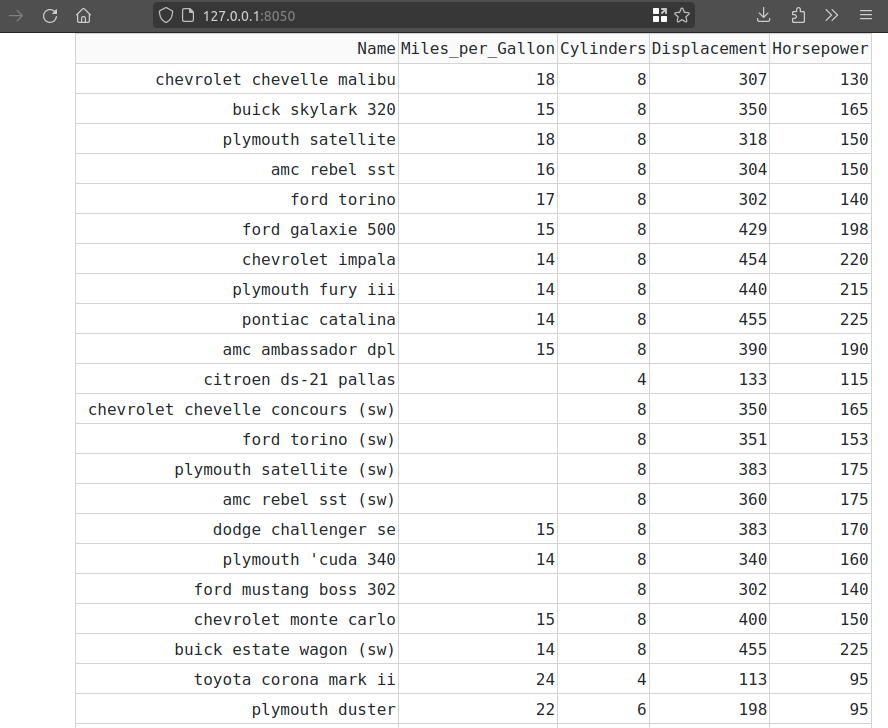

To have more control over how the columns are displayed and interacted with,
we can set them explicitly by specifying a dictionary
containing both the display name and backend ID of each column.

```python
table = dash_table.DataTable(
    cars.to_dict('records'),
    columns=[{"name": col, "id": col} for col in cars.columns],
)
```

The above gives the same output than before,
but we can also change how the values are displayed,
e.g. by replacing underscores with spaces in column names
to make them more readable.

```python
table = dash_table.DataTable(
    cars.to_dict('records'),
    columns=[{"name": col.replace('_', ' '), "id": col} for col in cars.columns],
)
```

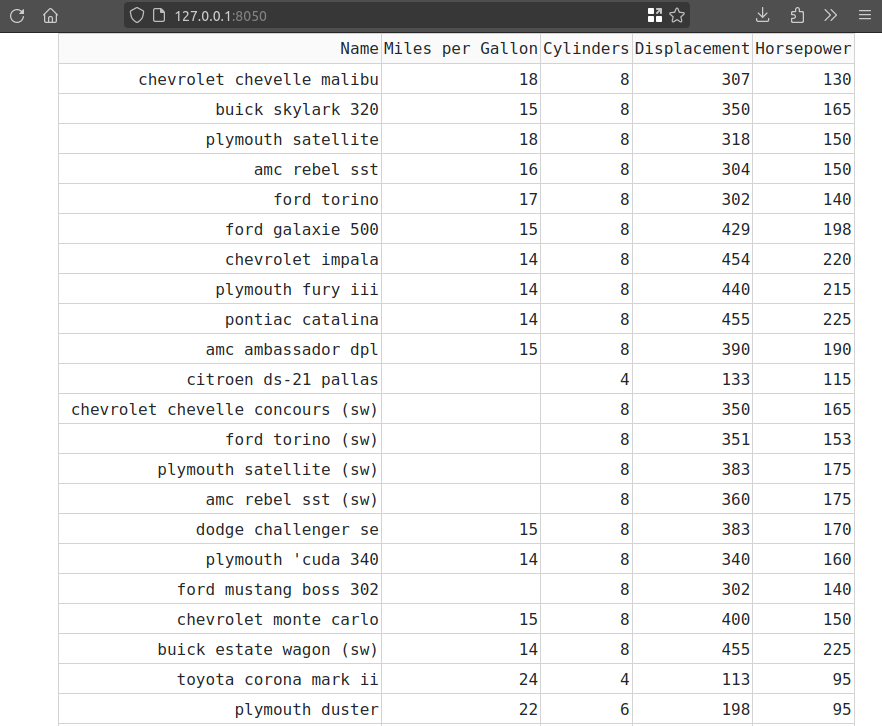

By setting the `page_size`,
we can control how many elements are displayed.

```python
table = dash_table.DataTable(
    cars.to_dict('records'),
    columns=[{"name": col.replace('_', ' '), "id": col} for col in cars.columns],
    page_size=10,
)
```

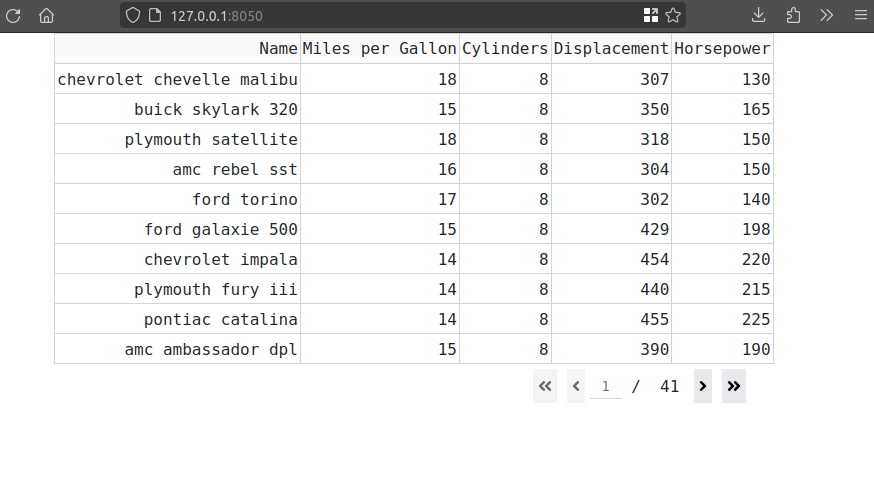

And we can even add built in sorting and filtering:

```python
table = dash_table.DataTable(
    cars.to_dict('records'),
    columns=[{"name": col.replace('_', ' '), "id": col} for col in cars.columns],
    columns=[{"name": col, "id": col} for col in cars.columns],
    page_size=10,
    sort_action='native',
    filter_action='native',
)
```

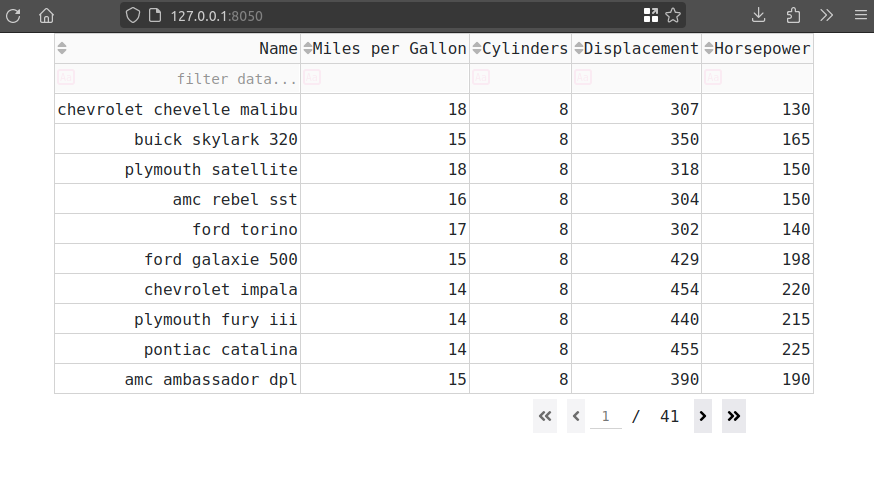

[Dash has it own filter syntax](https://dash.plotly.com/datatable/filtering),
which is similar to what we have used previously with dataframes.
You need to have specified the `columns` parameter for filtering to work.
After you type something in,
you need to press enter.
Here I filter for all car models with "mazda" in their name
and that are highly fuel efficient.

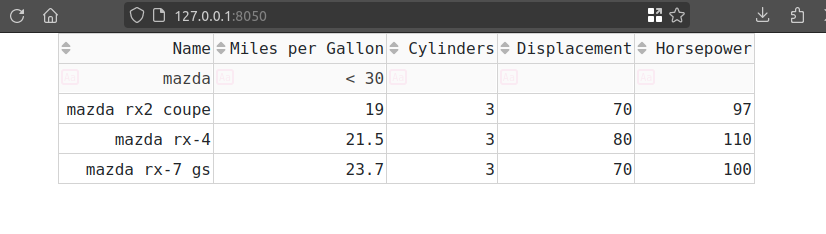

## Table callbacks

### Callbacks based on row filtering

We can now use these callbacks to drive plotting events,
just as we would have if we had used a dash core components widget.
Let's start by using the rows from the table to drive the callback.
We need to add an `id` to the table,
and output component (here a markdown region),
and then listen to the signal
`derived_virtual_data` from the table.

Our full app now looks like this:

```python
import dash_bootstrap_components as dbc
from dash import Dash, dash_table, dcc, callback, Input, Output
from vega_datasets import data
import pandas as pd


cars = data.cars().iloc[:, :5]  # First 5 columns to make it easier to demo/read

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(
    id='table',
    data=cars.to_dict('records'),
    columns=[{"name": col.replace('_', ' '), "id": col} for col in cars.columns],
    page_size=10,
    sort_action='native',
    filter_action='native',
)

# Layout
app.layout = dbc.Container(
    dbc.Row([
        dbc.Col(table),
        dcc.Markdown(id='output-div')
    ])
)

@callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
)
def update_markdown(rows):
    [print(row) for row in rows]  # To see the returned data in the console
    return(pd.DataFrame(rows).to_markdown())

if __name__ == '__main__':
    app.run(debug=True)
```

And if we type something in the table filter,
we will see that the markdown table is updated to contain only the filtered data.

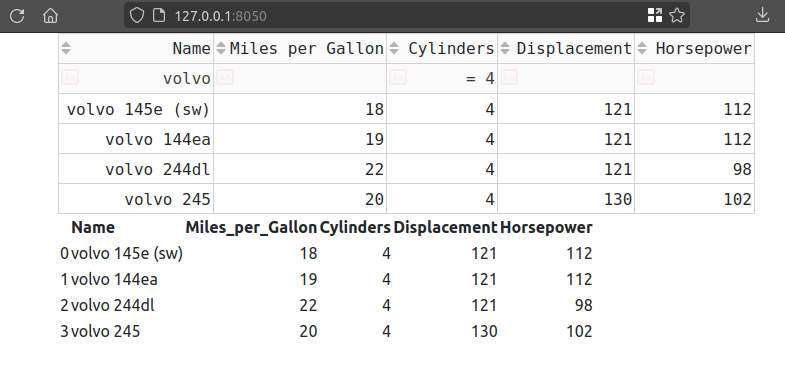

And if we look in the terminal,
we can see that the format of the returned data
(the `rows` variable)
is a dictionary per row in the dataframe
("records" format):

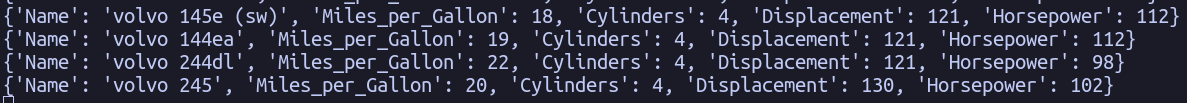

[The docs details several other row-related virtual signals](https://dash.plotly.com/datatable/interactivity) you could hook up a callback to.

### Callbacks based on column selection

To create callbacks based on the columns,
we first need to make them selectable.
To make columns selectable,
we need to set the `selectable` property for each column,
and specify the `column_selectable` parameter.
Here, we also set the default `selected_columns`
and avoid 
we need to add three lines
(also showing how to avoid making all columns selectable,
we're skipping `'name'` here:

```python
# Components
table = dash_table.DataTable(
    id='table',
    data=cars.to_dict('records'),
    columns=[  # A list of dictionaries, each representing a column
        {
            "name": col.replace('_', ' '),
            "id": col,
            'selectable': False if col == 'Name' else True
        }
        for col in cars.columns
    ],
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=10,
    sort_action='native',
    filter_action='native',
)
```

You can see that a radio button is added to all the columns except "Name"
and that there is a default selection.

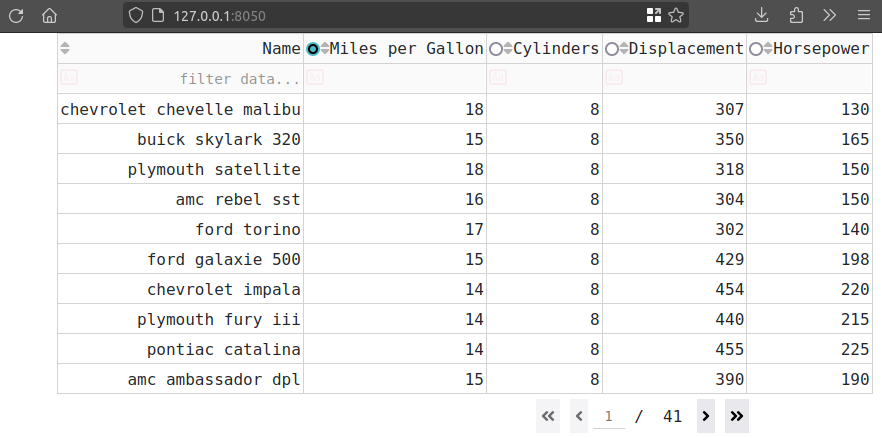

Now we can listen to the column (and row) selection
by extending up our callback:

```python
@callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
)
def update_markdown(rows, columns):
    print(columns)  # A list of column names as strings
    return(pd.DataFrame(rows)[columns].to_markdown())
```

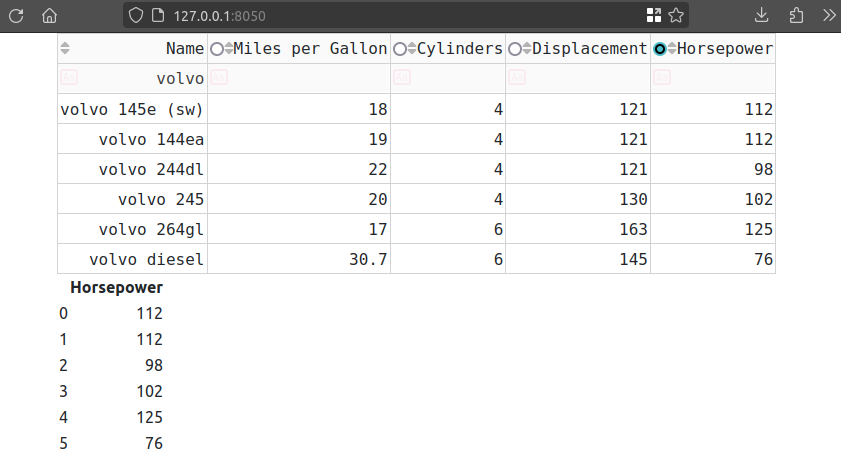

Our entire `app.py` now looks like this:

```python
import dash_bootstrap_components as dbc
from dash import Dash, dash_table, dcc, callback, Input, Output
from vega_datasets import data
import pandas as pd


cars = data.cars().iloc[:, :5]  # First 5 columns to make it easier to demo/read

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(
    id='table',
    data=cars.to_dict('records'),
    columns=[  # A list of dictionaries, each representing a column
        {
            "name": col.replace('_', ' '),
            "id": col,
            'selectable': False if col == 'Name' else True
        }
        for col in cars.columns
    ],
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=10,
    sort_action='native',
    filter_action='native',
)

# Layout
app.layout = dbc.Container(
    dbc.Row([
        dbc.Col(table),
        dcc.Markdown(id='output-div')
    ])
)

@callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
)
def update_markdown(rows, columns):
    [print(row) for row in rows]  # A list of rows as dictionaries/records
    print(columns)  # A list of column names as strings
    return(pd.DataFrame(rows)[columns].to_markdown())

if __name__ == '__main__':
    app.run(debug=True)
```

### Updating a table based on a callback

For callbacks from other widgets or from plotly plots,
you can treat tables as any other output element
and target their `columns` and `data` attributes to update them
via a callback function.
Here we add a dropdown,
and a callback listening to the dropdown
to update the table.

```python
import dash_bootstrap_components as dbc
from dash import Dash, dash_table, dcc, callback, Input, Output
from vega_datasets import data
import pandas as pd


cars = data.cars()

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(
    id='table',
    # The data and columns parameters are set in the callback instead
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=10,
    sort_action='native',
    filter_action='native',
)
dropdown = dcc.Dropdown(
    id='dropdown',
    options=cars.columns,
    value=['Name', 'Miles_per_Gallon', 'Horsepower'],
    multi=True
)

# Layout
app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([dropdown, table]),
        dbc.Col(dcc.Markdown(id='output-div'))
    ])
)

# This callback sets the default values of the table
# (since there is a default value in the dropdown)
# and then updates each time the dropdown is changes
@callback(
    Output('table', "columns"),
    Output('table', "data"),
    Input('dropdown', "value"),
)
def update_table(dropdown_cols):
    print(dropdown_cols)
    return(
        [  # A list of dictionaries, each representing a column
            {
                "name": col.replace('_', ' '),
                "id": col,
                'selectable': False if col == 'Name' else True
            }
            for col in dropdown_cols
        ],
        cars[dropdown_cols].to_dict('records')
    )


@callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
    prevent_initial_call=True  # Avoid triggering before the table has a selected column
)
def update_markdown(table_rows, table_column):
    return pd.DataFrame(table_rows)[table_column].to_markdown()

if __name__ == '__main__':
    app.run(debug=True)
```

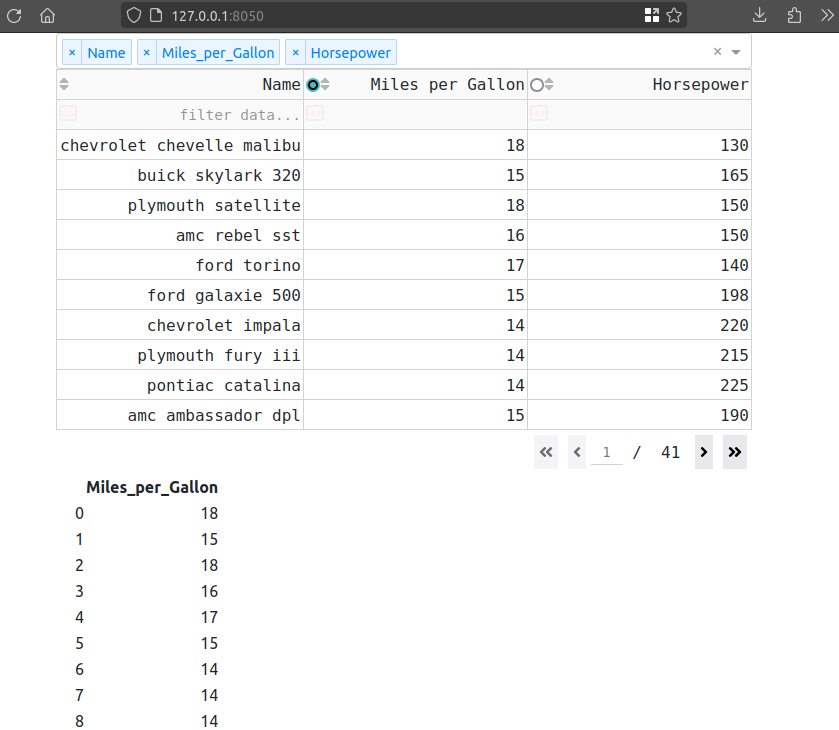

Here is a more complex application of what we just learned,
that links the table callbacks to charts instead.

```python
from dash import Dash, dash_table, dcc, callback, Input, Output
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
from vega_datasets import data
import pandas as pd
import altair as alt


cars = data.cars()

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(
    id='table',
    # The data and columns parameters are set in the callback instead
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=5,
    sort_action='native',
    filter_action='native',
)
dropdown = dcc.Dropdown(
    id='dropdown',
    options=cars.columns,
    value=['Name', 'Miles_per_Gallon', 'Horsepower'],
    multi=True
)
scatter = dvc.Vega(
    id='scatter',
    opt={'actions': False},  # Remove the three dots button
    style={'width': '100%'}
)
histogram = dvc.Vega(
    id='histogram',
    opt={'actions': False},  # Remove the three dots button
    style={'width': '100%'}
)

# Layout
app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([dropdown, table]),
        dbc.Row([
            dbc.Col(histogram),
            dbc.Col(scatter),
        ]),
    ])
)

@callback(
    Output('table', "columns"),
    Output('table', "data"),
    Input('dropdown', "value"),
)
def update_table(dropdown_cols):
    print(dropdown_cols)
    return(
        [  # A list of dictionaries, each representing a column
            {
                "name": col.replace('_', ' '),
                "id": col,
                'selectable': False if col == 'Name' else True
            }
            for col in dropdown_cols
        ],
        cars[dropdown_cols].to_dict('records')
    )


@callback(
    Output('histogram', "spec"),
    Output('scatter', "spec"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
    prevent_initial_call=True  # Avoid triggering before the table has a selected column
)
def update_(table_rows, table_column):
    histogram = alt.Chart(pd.DataFrame(table_rows), width='container').mark_bar().encode(
        alt.X(f'{table_column[0]}:Q').bin(maxbins=30),
        alt.Y('count()')
    )
    scatter = alt.Chart(pd.DataFrame(table_rows), width='container').mark_area().transform_density(
        table_column[0],
        as_=[table_column[0], 'density']
    ).encode(
        alt.X(f'{table_column[0]}:Q'),
        alt.Y('density:Q'),
    )
    return histogram.to_dict(), scatter.to_dict()


if __name__ == '__main__':
    app.run(debug=True)
```

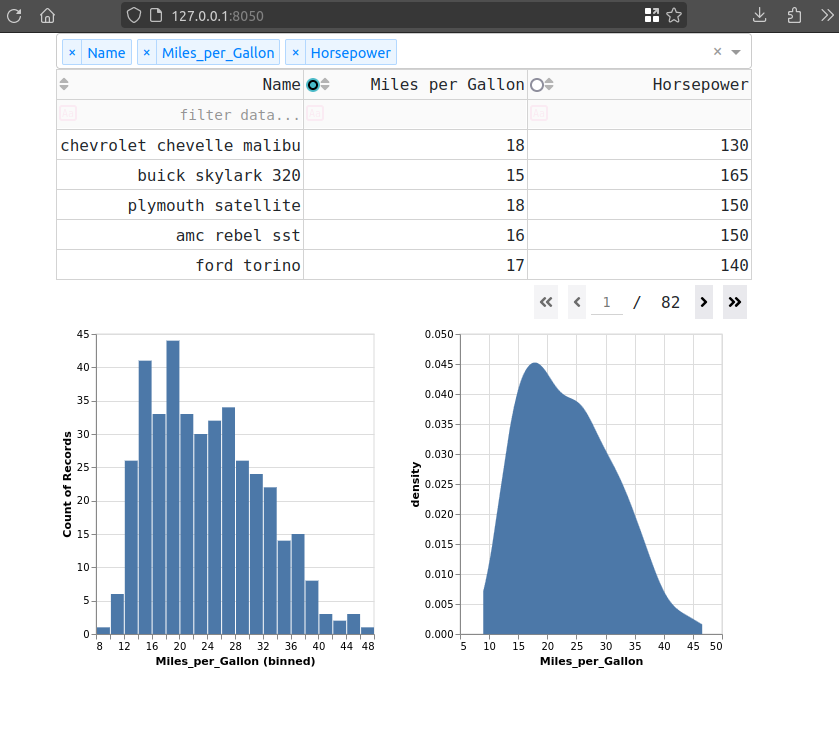

## Styling

We have already seen how to use stylesheets to set a general theme for out app.
In addition,
there are smaller modifications that we can make
to adjust the appearance of our app.

You can also style individual HTML components,
and set HTML properties such as class names, etc,
by passing a CSS configuration as a dictionary
to the `style` parameter.

```python
import dash_bootstrap_components as dbc
from dash import Dash, html


# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(
            html.Div('Hello dash', style={'color': 'blue', 'fontSize': 44}), 
            style={'border': '2px solid black', 'padding': 10}
        ),
        dbc.Col(
            html.P('Hi there', id='my-para', style={'background-color':'red'}),
            style={'border': '3px dotted rebeccapurple', 'padding': 20}
        )
    ],
    style={'marginTop': 50, 'border': '5px dashed coral', 'padding': 10}
    )
])

if __name__ == '__main__':
    app.run(debug=True)
```

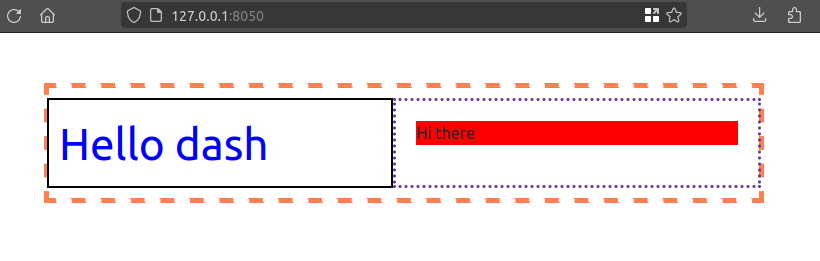

Covering everything you can do in CSS is beyond the scope of this lecture,
but we will highlight some helpful parts.

### Creating an appealing dashboard title

To make your dashboard standout,
you can create a title that is more than just black text on a white background.
There are many options here,
including using a sidebar or navbar for the title,
but a simple styled header is a good default choice.

```python
import dash_bootstrap_components as dbc
from dash import Dash, html


# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
title = html.H1(
    'My splashboard demo',
    style={
        'backgroundColor': 'steelblue',
        'padding': 20,
        'color': 'white',
        'margin-top': 20,
        'margin-bottom': 20,
        'text-align': 'center',
        'font-size': '48px',
        'border-radius': 3,
    }
)

# Layout
app.layout = dbc.Container([
    dbc.Row(dbc.Col(title)),
])

if __name__ == '__main__':
    app.run(debug=True)
```

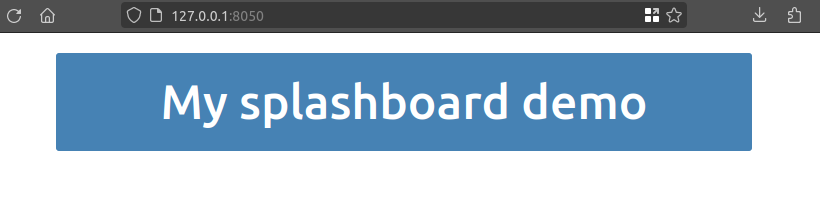

### Creating a sidebar for global widgets

We can style a column and place all widgets in it
to create the appearance of a dedicated global widgets sidebar.

```python
import dash_bootstrap_components as dbc
from dash import Dash, html, dcc


# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
title = html.H1(
    'My splashboard demo',
    style={
        'backgroundColor': 'steelblue',
        'padding': 20,
        'color': 'white',
        'margin-top': 20,
        'margin-bottom': 20,
        'text-align': 'center',
        'font-size': '48px',
        'border-radius': 3,
    }
)
sidebar = dbc.Col([
    html.H5('Global controls'),
    html.Br(),
    dcc.Dropdown(),
    html.Br(),
    dcc.Dropdown(),
    html.Br(),
    dcc.Dropdown(),
    ],
    md=3,
    style={
        'background-color': '#e6e6e6',
        'padding': 15,
        'border-radius': 3
    }
) 

# Layout
app.layout = dbc.Container([
    dbc.Row(dbc.Col(title)),
    dbc.Row(dbc.Col(sidebar)),
])

if __name__ == '__main__':
    app.run(debug=True)

```

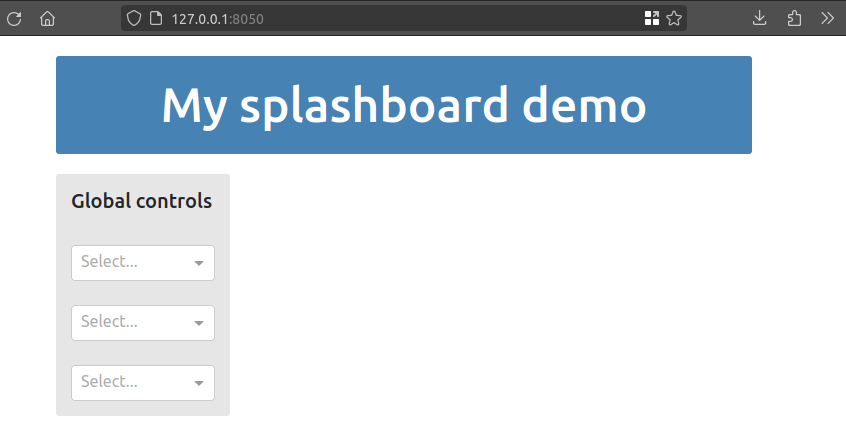

### Putting it together

We can combine this with our previous app
to create a complete dashboard:

<details><summary>Click to show code</summary>

```python
from dash import Dash, dash_table, dcc, callback, Input, Output, html
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
from vega_datasets import data
import pandas as pd
import altair as alt


cars = data.cars()

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
title = html.H1(
    'My splashboard demo',
    style={
        'backgroundColor': 'steelblue',
        'padding': 20,
        'color': 'white',
        'margin-top': 20,
        'margin-bottom': 20,
        'text-align': 'center',
        'font-size': '48px',
        'border-radius': 3,
        'margin-left': -10,  # Align with sidebar
    }
)

table = dash_table.DataTable(
    id='table',
    # The data and columns parameters are set in the callback instead
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=5,
    sort_action='native',
    filter_action='native',
)

dropdown = dcc.Dropdown(
    id='dropdown',
    options=cars.columns,
    value=['Name', 'Miles_per_Gallon', 'Horsepower'],
    multi=True
)

scatter = dvc.Vega(
    id='scatter',
    opt={'actions': False},  # Remove the three dots button
    style={'width': '100%'}
)

histogram = dvc.Vega(
    id='histogram',
    opt={'actions': False},  # Remove the three dots button
    style={'width': '100%'}
)

sidebar = dbc.Col([
    html.H5('Global controls'),
    html.Br(),
    dropdown,
    html.Br(),
    dcc.Dropdown(),
    html.Br(),
    dcc.Dropdown(),
    ],
    md=3,
    style={
        'background-color': '#e6e6e6',
        'padding': 10,
        'border-radius': 3,
    }
) 


# Layout
app.layout = dbc.Container([
    dbc.Row(dbc.Col(title)),
    dbc.Row([
        sidebar,  # Already wrapped in dbc.Col
        dbc.Col([
            dbc.Col([table]),
            dbc.Row([
                dbc.Col(histogram),
                dbc.Col(scatter),
            ])
        ],
        md=9),
    ])
])

@callback(
    Output('table', "columns"),
    Output('table', "data"),
    Input('dropdown', "value"),
)
def update_table(dropdown_cols):
    return(
        [  # A list of dictionaries, each representing a column
            {
                "name": col.replace('_', ' '),
                "id": col,
                'selectable': False if col == 'Name' else True
            }
            for col in dropdown_cols
        ],
        cars[dropdown_cols].to_dict('records')
    )


@callback(
    Output('histogram', "spec"),
    Output('scatter', "spec"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
    prevent_initial_call=True  # Avoid triggering before the table has a selected column
)
def update_(table_rows, table_column):
    histogram = alt.Chart(pd.DataFrame(table_rows), width='container').mark_bar().encode(
        alt.X(f'{table_column[0]}:Q').bin(maxbins=30),
        alt.Y('count()')
    )
    scatter = alt.Chart(pd.DataFrame(table_rows), width='container').mark_area().transform_density(
        table_column[0],
        as_=[table_column[0], 'density']
    ).encode(
        alt.X(f'{table_column[0]}:Q'),
        alt.Y('density:Q'),
    )
    return histogram.to_dict(), scatter.to_dict()


if __name__ == '__main__':
    app.run(debug=True)
```

</details>

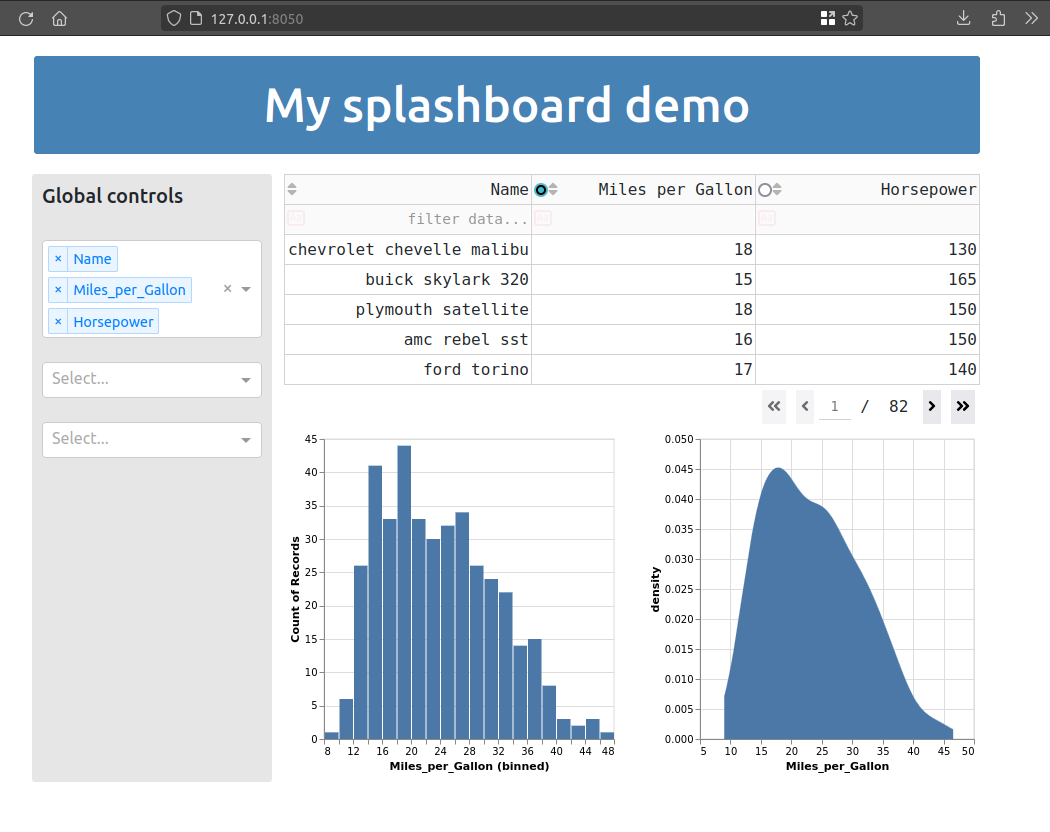

If your layout looks messy,
a tip is to use cards
to make elements in the plot more contained.
Next we wrap the two charts in cards
and also show how to apply styling to the table.

<details><summary>Click to view the code</summary>

```python
from dash import Dash, dash_table, dcc, callback, Input, Output, html
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
from vega_datasets import data
import pandas as pd
import altair as alt


cars = data.cars()

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
title = html.H1(
    'My splashboard demo',
    style={
        'backgroundColor': 'steelblue',
        'padding': 20,
        'color': 'white',
        'margin-top': 20,
        'margin-bottom': 20,
        'text-align': 'center',
        'font-size': '48px',
        'border-radius': 3,
        'margin-left': -10,  # Align with sidebar
    }
)

table = dbc.Col(
    dash_table.DataTable(
        id='table',
        # The data and columns parameters are set in the callback instead
        column_selectable="single",
        selected_columns=['Miles_per_Gallon'], 
        page_size=8,
        sort_action='native',
        filter_action='native',
        style_data_conditional=[{
            'if': {'row_index': 'odd'},
            'backgroundColor': 'rgb(248, 248, 248)'
        }],
         style_header={
            'backgroundColor': 'rgb(230, 230, 230)',
            'fontWeight': 'bold'
        },
        style_as_list_view=True,
        editable=True,
    ),
)

dropdown = dcc.Dropdown(
    id='dropdown',
    options=cars.columns,
    value=['Name', 'Miles_per_Gallon', 'Horsepower'],
    multi=True
)

density = dbc.Card([
    dbc.CardHeader('Density', style={'fontWeight': 'bold'}),
    dbc.CardBody(
        dvc.Vega(
            id='scatter',
            opt={'actions': False},  # Remove the three dots button
            style={'width': '100%'}
        )
    )
])

histogram = dbc.Card([
    dbc.CardHeader('Histrogram', style={'fontWeight': 'bold'}),
    dbc.CardBody(
        dvc.Vega(
            id='histogram',
            opt={'actions': False},  # Remove the three dots button
            style={'width': '100%'}
        )
    )
])

sidebar = dbc.Col([
    html.H5('Global controls'),
    html.Br(),
    dropdown,
    html.Br(),
    dcc.Dropdown(),
    html.Br(),
    dcc.Dropdown(),
    ],
    md=3,
    style={
        'background-color': '#e6e6e6',
        'padding': 10,
        'border-radius': 3,
    }
) 


# Layout
app.layout = dbc.Container([
    dbc.Row(dbc.Col(title)),
    dbc.Row([
        sidebar,  # Already wrapped in dbc.Col
        dbc.Col([
            table, # Already wrapped in dbc.Col
            dbc.Row([
                dbc.Col(histogram),
                dbc.Col(density),
            ])
        ],
        md=9),
    ])
])

@callback(
    Output('table', "columns"),
    Output('table', "data"),
    Input('dropdown', "value"),
)
def update_table(dropdown_cols):
    return(
        [  # A list of dictionaries, each representing a column
            {
                "name": col.replace('_', ' '),
                "id": col,
                'selectable': False if col == 'Name' else True
            }
            for col in dropdown_cols
        ],
        cars[dropdown_cols].to_dict('records')
    )


@callback(
    Output('histogram', "spec"),
    Output('scatter', "spec"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
    prevent_initial_call=True  # Avoid triggering before the table has a selected column
)
def update_(table_rows, table_column):
    histogram = alt.Chart(pd.DataFrame(table_rows), width='container').mark_bar().encode(
        alt.X(f'{table_column[0]}:Q').bin(maxbins=30),
        alt.Y('count()')
    )
    scatter = alt.Chart(pd.DataFrame(table_rows), width='container').mark_area().transform_density(
        table_column[0],
        as_=[table_column[0], 'density']
    ).encode(
        alt.X(f'{table_column[0]}:Q'),
        alt.Y('density:Q'),
    )
    return histogram.to_dict(), scatter.to_dict()


if __name__ == '__main__':
    app.run(debug=True)

```

</details>

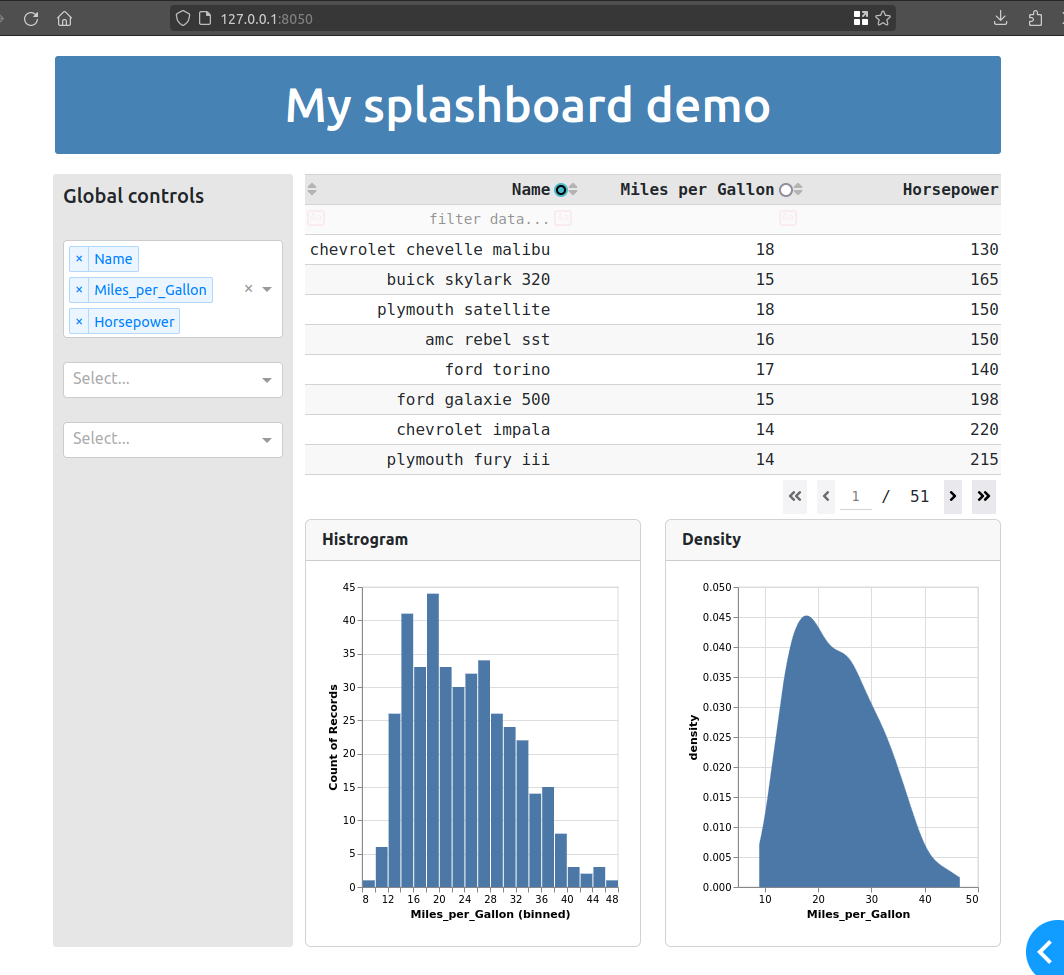